In [36]:
import pandas as pd
import numpy as np
import sklearn

In [37]:
URL = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv'
df = pd.read_csv(URL)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [38]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

X_train = train_set.drop('median_house_value', axis=1)
y = train_set['median_house_value']

X_num = X_train.drop('ocean_proximity', axis=1)

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_IX, bedrooms_IX, population_IX, households_IX = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_IX]/X[:, households_IX]
        population_per_household = X[:, households_IX]/X[:, population_IX]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_IX]/X[:, rooms_IX]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attributers', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])


In [41]:
from sklearn.compose import ColumnTransformer

num_attribs = list(X_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

In [42]:
X_prepared = full_pipeline.fit_transform(X_train)

In [43]:
X_prepared

array([[ 1.27258656, -1.3728112 ,  0.34849025, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.70916212, -0.87669601,  1.61811813, ...,  0.        ,
         0.        ,  1.        ],
       [-0.44760309, -0.46014647, -1.95271028, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.59946887, -0.75500738,  0.58654547, ...,  0.        ,
         0.        ,  0.        ],
       [-1.18553953,  0.90651045, -1.07984112, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41489815,  0.99543676,  1.85617335, ...,  0.        ,
         1.        ,  0.        ]])

Linear Regression

In [44]:
from sklearn.linear_model import LinearRegression

LR_model = LinearRegression()

In [45]:
LR_model.fit(X_prepared, y)

LinearRegression()

In [77]:
test_data = X_train.sample(10, random_state=42)
test_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
2071,-119.85,36.74,35.0,1191.0,190.0,537.0,182.0,3.5375,INLAND
2612,-124.16,41.02,23.0,1672.0,385.0,1060.0,390.0,2.1726,NEAR OCEAN
10838,-117.92,33.67,14.0,6224.0,1679.0,3148.0,1589.0,4.2071,<1H OCEAN
4061,-118.45,34.15,10.0,1091.0,260.0,517.0,266.0,4.1727,<1H OCEAN
10767,-117.90,33.63,28.0,2370.0,352.0,832.0,347.0,7.1148,<1H OCEAN
9778,-121.13,36.21,27.0,1476.0,352.0,1156.0,358.0,3.1929,<1H OCEAN
11317,-117.97,33.77,22.0,2244.0,575.0,1543.0,533.0,2.6618,<1H OCEAN
2454,-119.56,36.53,19.0,2746.0,495.0,1670.0,518.0,3.2019,INLAND
10394,-117.67,33.54,16.0,2102.0,350.0,1003.0,328.0,4.7981,<1H OCEAN
20002,-119.21,36.10,30.0,1471.0,373.0,1418.0,357.0,1.7432,INLAND


In [78]:
test_label = y.loc[test_data.index]
test_label

2071      96700.0
2612      75500.0
10838    430900.0
4061     332600.0
10767    500001.0
9778     137900.0
11317    179600.0
2454      95700.0
10394    170800.0
20002     42500.0
Name: median_house_value, dtype: float64

In [79]:
test_data_prepared = full_pipeline.transform(test_data)
predicted_labels = LR_model.predict(test_data_prepared)
predicted_labels

array([135346.97556832, 120622.24537497, 286068.95877777, 261810.3843136 ,
       362384.54870783, 201854.62513545, 168689.69761879,  97772.87728131,
       226731.4623406 ,  45610.57513619])

In [80]:
tp_data = pd.DataFrame({"Actual": test_label, "Predicted": predicted_labels})
tp_data

,Actual,Predicted
2071,96700.0,135346.975568
2612,75500.0,120622.245375
10838,430900.0,286068.958778
4061,332600.0,261810.384314
10767,500001.0,362384.548708
9778,137900.0,201854.625135
11317,179600.0,168689.697619
2454,95700.0,97772.877281
10394,170800.0,226731.462341
20002,42500.0,45610.575136


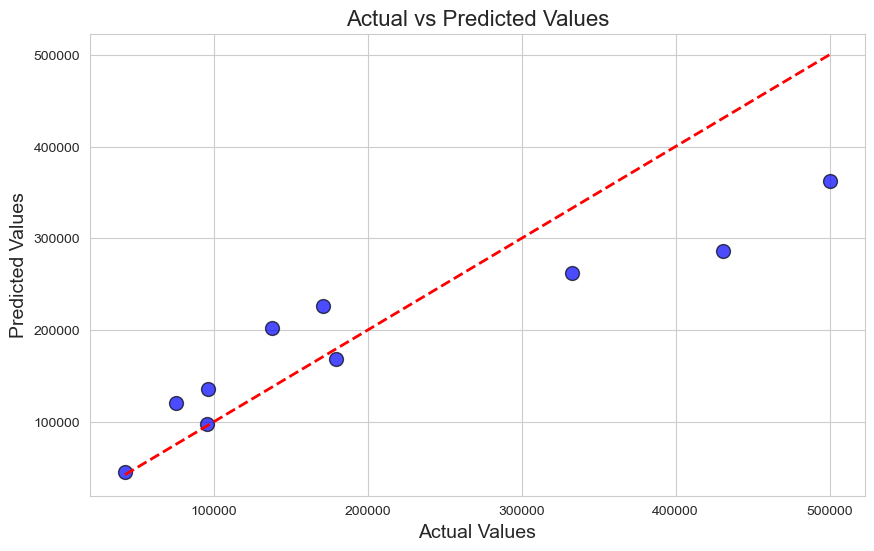

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(tp_data['Actual'], tp_data['Predicted'], color='b', edgecolor='k', alpha=0.7, s=100)

# Plotting the line of perfect prediction
plt.plot([tp_data['Actual'].min(), tp_data['Actual'].max()], [tp_data['Actual'].min(), tp_data['Actual'].max()], 'r--', lw=2)

# Adding titles and labels
plt.title('Actual vs Predicted Values', fontsize=16)
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)

# Adding a grid
plt.grid(True)

# Show the plot
plt.show()

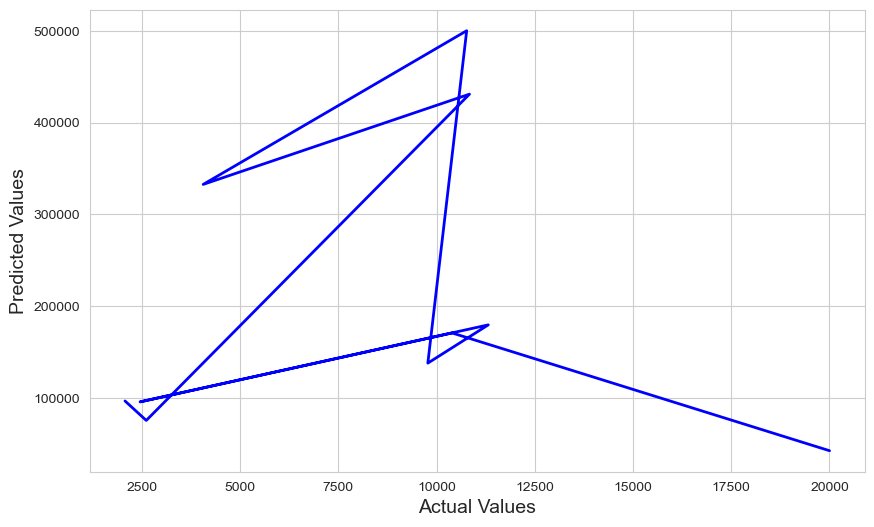

In [82]:
im